Improvements to the Phoenix model

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [23]:
import prepare_phoenix

#{'Teff':data['Teff__0'], 'logg': logg, 'FeH': FeH, 'aM': aM}
Params from B+M 17: https://ui.adsabs.harvard.edu/abs/2017ApJ...845..110B/abstract


In [67]:
#b+m17
#teff = 2650*u.K
#distance = 12.49*u.pc #~consistant with gaia
#mass = 0.080*u.M_sun
#radius = 0.121*u.R_sun

#g+17
#teff = 2559*u.K
#distance = 12.1*u.pc
#mass = 0.080*u.M_sun
#radius = 0.117*u.R_sun

#gonzales+19 w. gaia! https://arxiv.org/pdf/1909.13859.pdf
teff = 2628*u.K
distance = 12.43*u.pc
mass = 90*u.M_jup
radius = 1.16*u.R_jup
logg = 5.21
FeH = 0.04
#g = ((const.G.to(u.cm**3/(u.g*u.s**2))*mass.to(u.g))/(radius.to(u.cm)**2))
#print(g)
#logg = np.log10(g.value)
#print(logg)

In [68]:
star_params =  {'Teff':teff.value, 'logg': logg, 'FeH': FeH, 'aM': 0}

In [69]:
wavefile= 'WAVE_PHOENIX-ACES-AGSS-COND-2011.fits'
savepath = ''
pw, pf =prepare_phoenix.make_phoenix_spectrum('trappist-1',wavefile, '.', '.', star_params, save_ecsv=True, plot=False)

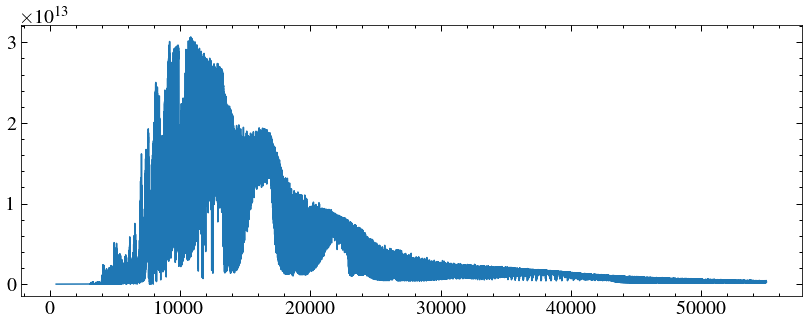

In [70]:
plt.plot(pw, pf)

Ok let's scale with distance and wavelength rather than fitting. Current = 1.59e-28 

In [151]:
old_scale = 1.59e-28
scale = ((radius.to(u.cm)/distance.to(u.cm))**2)*1e-8 #correcting to A
print(scale)
#mscale = 4.7527382752515984e-20

4.675063607400832e-28


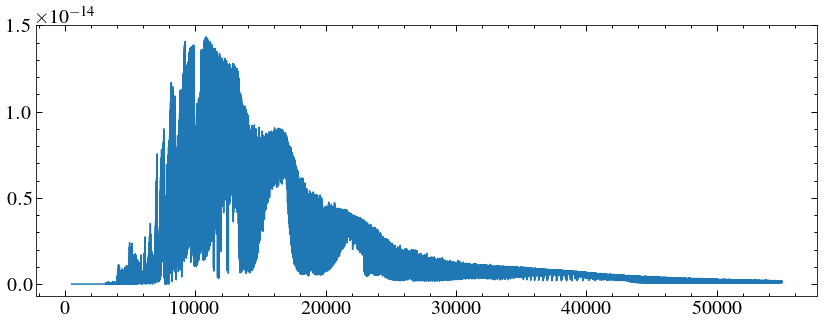

In [75]:
plt.plot(pw, pf*scale)

(0, 3e-14)

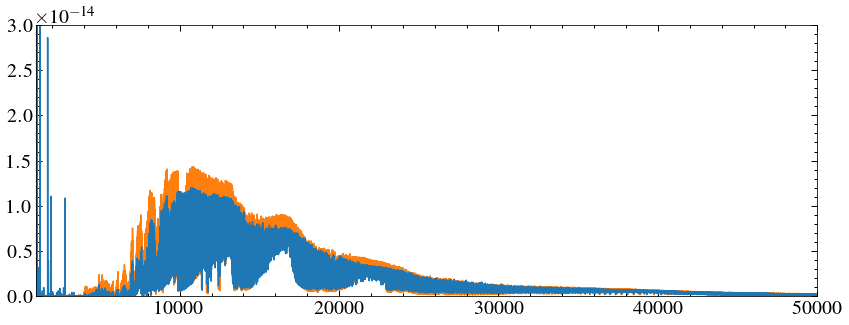

In [152]:
mpath = '/home/david/work/muscles/trappist-1/sp_models/'
mods = os.listdir(mpath)
for mod in mods[0:1]:
    mw, mf = np.loadtxt(mpath+mod, unpack=True, skiprows=1)
    plt.plot(mw, mf*scale/1e-8)
plt.plot(pw,pf*scale, zorder=-1)
plt.xlim(1000, 50000)
plt.ylim(0, 3e-14)
#plt.yscale('log')

In [31]:
hdul = fits.open('lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

In [32]:
hdul[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' / Wavelength array      
PHXTEFF =               2500.0 / [K] effective temperature                      
PHXLOGG =                  5.0 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
PHXDUST =                    F / Dust in atmosphere                             
PHXEOS  = 'ACES    '        

Flux is in per cm not per A!!!!!!! Fixed above. How does that compare to STIS?

In [120]:
stis_opt = 'odlm41010_sx1.fits'
data = fits.getdata('../combined/'+stis_opt,1)[0]
wo = data['WAVELENGTH'][data['DQ']==0]
fo = data['FLUX'][data['DQ']==0]
mask = (fo>0) &  (wo <3355) | (wo > 3365) & (wo < 5321) | (wo > 5325) & (wo < 5476.5) | (wo > 5480.5) #cutting out overlap and cosmics
wo, fo = wo[mask], fo[mask]

(1e-30, 1e-13)

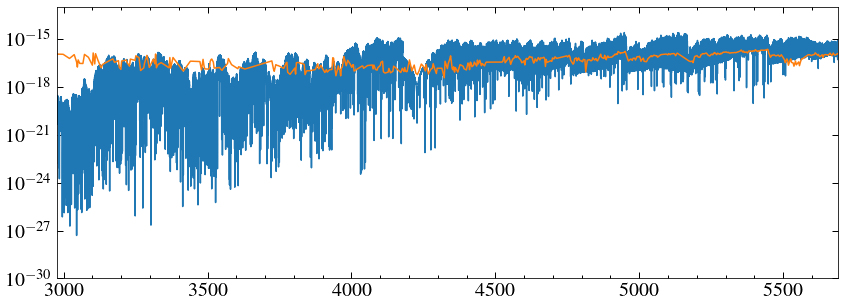

In [125]:
plt.plot(pw, pf*scale)
plt.plot(wo, fo)
plt.xlim(wo[0], wo[-1])
#plt.ylim(-0.1e-15, 0.3e-14)
plt.yscale('log')
plt.ylim(1e-30, 1e-13)

Reasonable, I think this is the better way forward given the scaling is almost included by the choice of model. What about the ir data?

In [88]:
irpath = '/home/david/work/muscles/SEDs/trappist-1/ir_data/'
#sps = os.listdir(irpath) 
sps = glob.glob(irpath+'*.fits')
sps

['/home/david/work/muscles/SEDs/trappist-1/ir_data/mage_2306-0502_090827.fits',
 '/home/david/work/muscles/SEDs/trappist-1/ir_data/spex_sxd-merge_2306-0502_151118.fits',
 '/home/david/work/muscles/SEDs/trappist-1/ir_data/spex_prism_2306-0502_030905.fits']

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


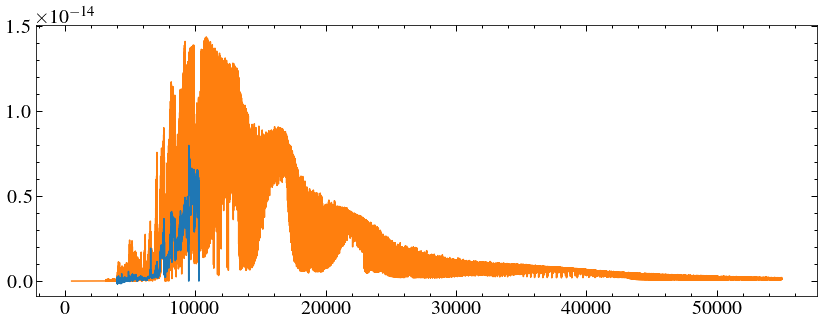

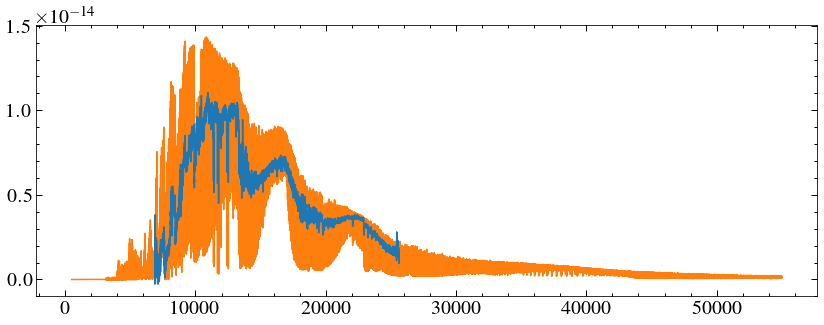

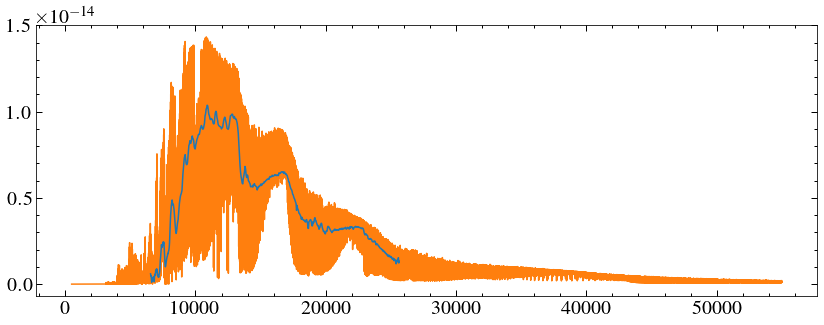

In [161]:
for i, sp in enumerate(sps):
  #  hdul = fits.open(sp, ignore_missing_end=True)
    
    #data = hdul[0].data
    data = fits.getdata(sp,0)
   # hdul.close()
    w, f, e = data[0], data[1], data[2]
    if i == 0:
        e = e/f
        f = (f *1e-3*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w * u.AA)).value
        #e = e*f
        f /=10
        e = e*f
        #clip = 100
        mask = (w > 4000)
        #w, f, e = w[clip:], f[clip:], e[clip:]
        w, f, e = w[mask], f[mask], e[mask]
    if i > 0:
        w *= 10000
    if i == 1:
        w, f, e, = w[:-10], f[:-10], e[:-10] #bad edge pixels
    if i ==2:
        f /=10 #erg/nm to erg/A I assume?
    plt.plot(w,f)
    name = os.path.split(sp)[1][:-5]
    #print(name)
    savedat = Table([w*u.AA, f*u.erg/u.cm**2/u.s/u.AA, e*u.erg/u.cm**2/u.s/u.A], names=['WAVELENGTH', 'FLUX', 'ERROR'])
    ascii.write(savedat, irpath+name+'.ecsv', overwrite=True, format='ecsv')
    #plt.plot(w,e)
    #plt.plot(w, f/e)
    #plt.xlim(3000, 4000)
    plt.plot(pw, pf*scale, zorder=-1)
    plt.show()
    #hdul[0].header
   

In [90]:
fits.getheader(sps[2])

SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                  562 /                                                
NAXIS2  =                    3 /                                                
EXTEND  =                    T /file may contain extensions                     

In [91]:
from astropy.convolution import convolve_fft
from astropy.convolution import Gaussian1DKernel

def smear(w,f, R, w_sample=1):
    '''
    Smears a model spectrum with a gaussian kernel to the given resolution, R.
    Adapeted from https://github.com/spacetelescope/pysynphot/issues/78

    Parameters
    -----------

    w,f:  spectrum to smear

    R: int
        The resolution (dL/L) to smear to

    w_sample: int
        Oversampling factor for smoothing

    Returns
    -----------

    sp: PySynphot Source Spectrum
        The smeared spectrum
    '''

    # Save original wavelength grid and units
    w_grid = w
    

    # Generate logarithmic wavelength grid for smoothing
    w_logmin = np.log10(np.nanmin(w_grid))
    w_logmax = np.log10(np.nanmax(w_grid))
    n_w = np.size(w_grid)*w_sample
    w_log = np.logspace(w_logmin, w_logmax, num=n_w)

    # Find stddev of Gaussian kernel for smoothing
    R_grid = (w_log[1:-1]+w_log[0:-2])/(w_log[1:-1]-w_log[0:-2])/2
    sigma = np.median(R_grid)/R
    if sigma < 1:
        sigma = 1

    # Interpolate on logarithmic grid
    f_log = np.interp(w_log, w_grid, f)

    # Smooth convolving with Gaussian kernel
    gauss = Gaussian1DKernel(stddev=sigma)
    f_conv = convolve_fft(f_log, gauss)

    # Interpolate back on original wavelength grid
    f_sm = np.interp(w_grid, w_log, f_conv)

    # Write smoothed spectrum back into Spectrum object
    return w_grid, f_sm

In [92]:
mage_res = 4100
sxd_res = 2000
prism_res = 200
reses = [mage_res, sxd_res, prism_res]

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


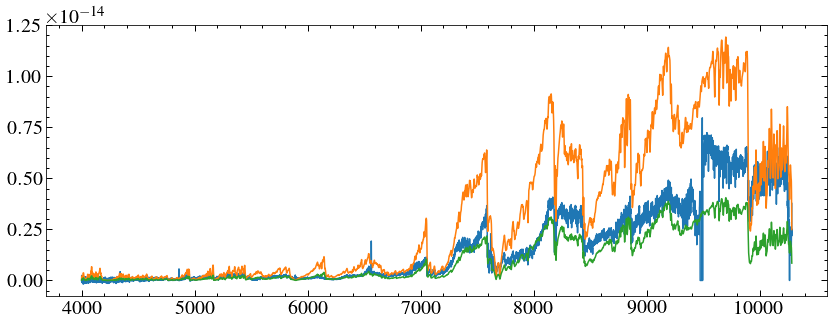

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in true_divide


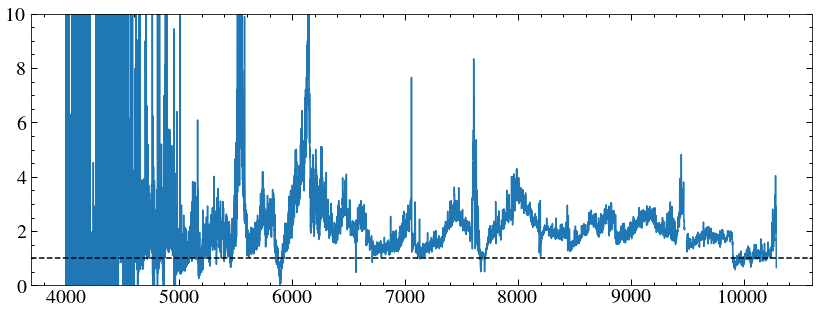

 ############################## Xspextool History ############################## [astropy.io.fits.card]
 ############################## Xcombspec History ############################## [astropy.io.fits.card]
 ############################### Xtellcor History ############################## [astropy.io.fits.card]
 ############################# Xmergeorders History ############################ [astropy.io.fits.card]


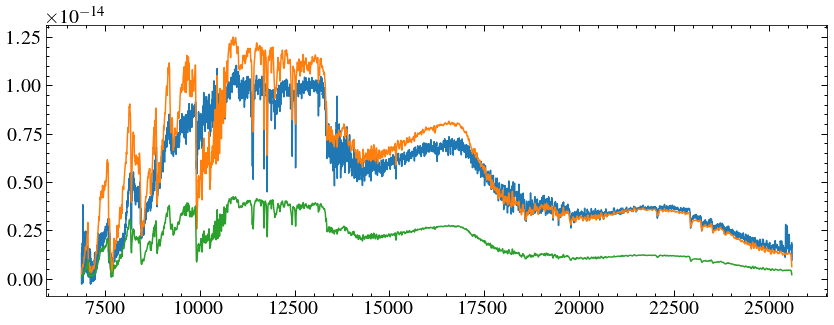

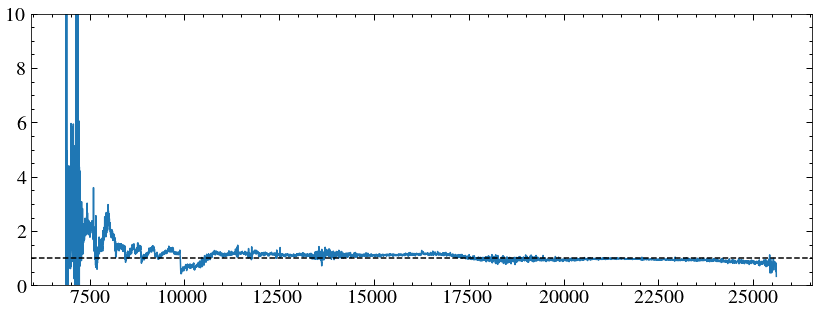

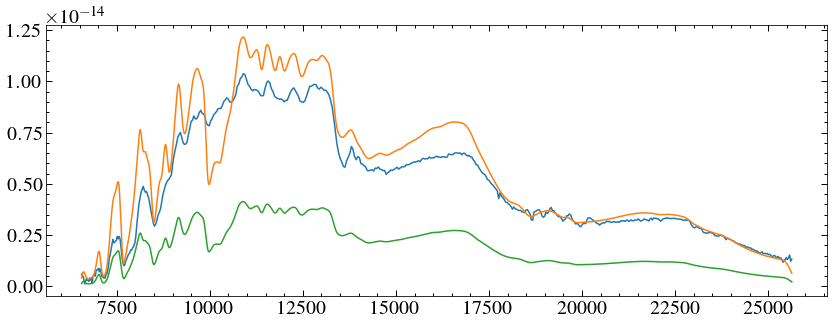

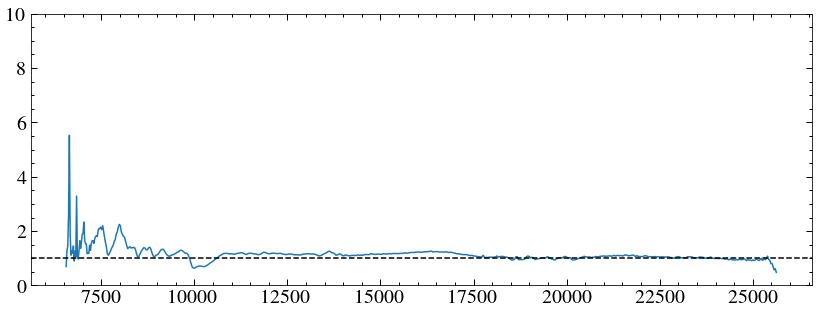

In [111]:
for i, sp in enumerate(sps):
  #  hdul = fits.open(sp, ignore_missing_end=True)
    
    #data = hdul[0].data
    data = fits.getdata(sp,0)
   # hdul.close()
    w, f, e = data[0], data[1], data[2]
    if i == 0:
        e = e/f
        f = (f *1e-3*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w * u.AA)).value
        e = e*f
        f /=10
        #clip = 100
        mask = (w > 4000)
        #w, f, e = w[clip:], f[clip:], e[clip:]
        w, f, e = w[mask], f[mask], e[mask]
    if i > 0:
        w *= 10000
    if i == 1:
        w, f, e, = w[:-10], f[:-10], e[:-10] #bad edge pixels
    if i ==2:
        f /=10 #erg/nm to erg/A I assume?
    plt.plot(w,f)
    #plt.plot(w,e)
    #plt.plot(w, f/e)
    #plt.xlim(3000, 4000)
    pmask = (pw >= w[0]) & (pw <= w[-1])
    pwr, pfr = pw[pmask],(pf*scale)[pmask]
    pwr, pfr = smear(pwr, pfr, reses[i])
    plt.plot(pwr, pfr)
    plt.plot(pwr, pfr*(old_scale/scale))
    plt.show()
    pfi = interp1d(pwr, pfr, fill_value='extrapolate')(w)
    plt.plot(w, pfi/f)
    plt.axhline(1, ls='--',c='k')
    plt.ylim(0,10)
    plt.show()
    #hdul[0].heade

A bit high in all three cases? A factor 2 missing somewhere? How do the three spectra compare themselves? Trying with different distance  

Changed to G+ values, much better agreement. Scale radius to Gaia?

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


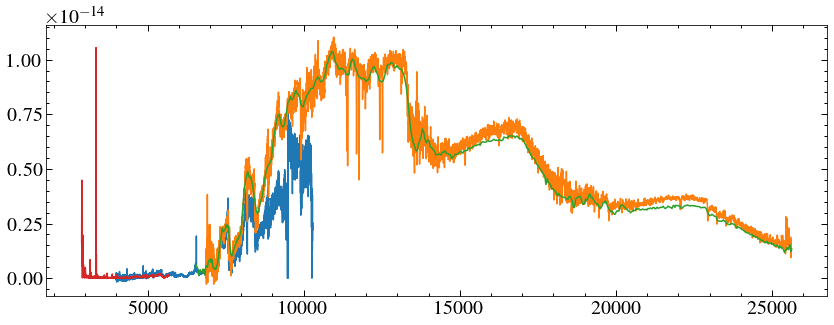

In [113]:
for i, sp in enumerate(sps):
    data = fits.getdata(sp,0)
    w, f, e = data[0], data[1], data[2]
    if i == 0:
        e = e/f
        f = (f *1e-3*u.Jy).to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(w * u.AA)).value
        e = e*f
        f /=10
        #clip = 100
        mask = (w > 4000)
        #w, f, e = w[clip:], f[clip:], e[clip:]
        w, f, e = w[mask], f[mask], e[mask]
    if i > 0:
        w *= 10000
    if i == 1:
        w, f, e, = w[:-10], f[:-10], e[:-10] #bad edge pixels
    if i ==2:
        f /=10 #erg/nm to erg/A I assume?
    plt.plot(w,f)
plt.plot(wo, fo)



4.7527382752515984e-20


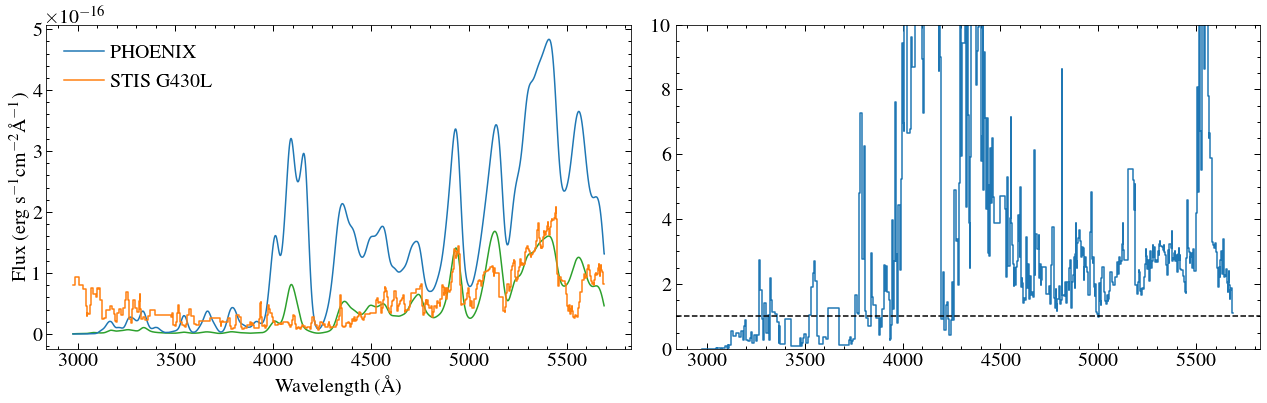

In [211]:
shift = 1
#plt.plot(w2fit, f2fit)
plt.figure(figsize=(18,6))
plt.subplot(121)
pmask = (pw >= wo[0]) & (pw <= wo[-1])
pwr, pfr = pw[pmask],(pf*scale)[pmask]
pwr, pfr = smear(pwr, pfr,250)
plt.step(pwr, pfr/shift, label='PHOENIX', where='mid')
fob = convolve(fo,Box1DKernel(2))
plt.step(wo, fob, where='mid', label='STIS G430L')
plt.legend(loc=2)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')

mscale = (((0.117*u.R_sun.to(u.cm))/(12.1*u.pc.to(u.cm)))**2)
print(mscale)
mwr, mfr = smear(mw[(mw >= wo[0]) & (mw <= wo[-1])], (mf*scale*1e8)[(mw >= wo[0]) & (mw <= wo[-1])], 250)
plt.plot(mwr, mfr, zorder=-1)



plt.subplot(122)
pfi = interp1d(pwr, pfr, fill_value='extrapolate')(wo)
plt.step(wo, (pfi/shift)/fo, where='mid')
plt.ylim(0,10)
plt.axhline(1, ls='--',c='k')
plt.tight_layout()

Have a new cgs spectrum from MV

In [136]:
newspec = glob.glob(irpath+'*.txt')[0]
newspec

'/home/david/work/muscles/SEDs/trappist-1/ir_data/trappist1_ir.txt'

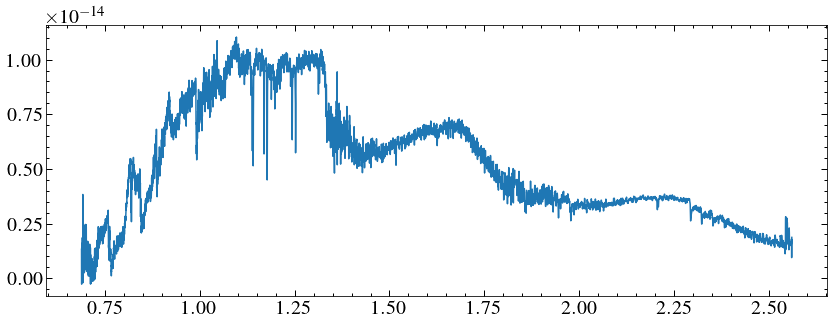

In [138]:
wn, fn = np.loadtxt(newspec, unpack=True)
plt.plot(wn[:-10], fn[:-10])

In [139]:
fits.getheader('lte02500-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits')

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =              1569128                                                  
EXTEND  =                    T                                                  
EXTNAME = 'PRIMARY '                                                            
WAVE    = '../../WAVE_PHOENIX-ACES-AGSS-COND-2011.fits' / Wavelength array      
PHXTEFF =               2500.0 / [K] effective temperature                      
PHXLOGG =                  5.0 / [cm/s^2] log (surface gravity)                 
PHXM_H  =                  0.0 / [M/H] metallicity (rel. sol. - Asplund &a 2009)
PHXALPHA=                  0.0 / [a/M] alpha element enhancement                
PHXDUST =                    F / Dust in atmosphere                             
PHXEOS  = 'ACES    '        

In [167]:
#plt.step(wo, fo, where='mid')
#for smooth in (5,5):#, 10, 15, 20):
 #   plt.step(wo, convolve(fo,Box1DKernel(smooth)), where='mid', label=str(smooth))
#plt.legend()

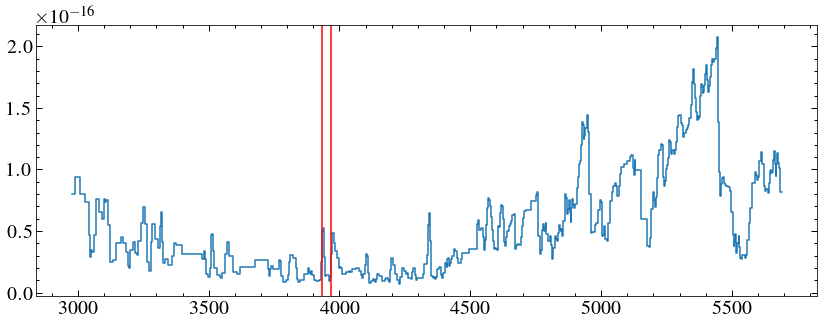

In [156]:
ca =[ 3933.6614, 3968.4673]
plt.step(wo,  convolve(fo,Box1DKernel(2)), where='mid')
[plt.axvline(line, c='r') for line in ca]

Hey look Ca H&K lines! How does photometry compare?

In [168]:
phottab = 'trappist-1_vizer_photometry.vot'
from astropy.io.votable import parse
votable = parse(phottab)
table = votable.get_first_table()
data = table.array

[21900.24530645 21900.24530645 16300.15539365 16300.15539365
 12500.20672977 12500.20672977 21637.85333815 16494.77072902
 12390.16606051 33500.10705107 33500.10705107 21637.85333815
 16494.77072902 12390.16606051 21637.85333815 16494.77072902
 12390.16606051 12390.16606051 21637.85333815 16494.77072902
 12390.16606051 21637.85333815 12390.16606051 33500.10705107
 12390.16606051] Angstrom [3.05655091e-15 3.10655575e-15 6.04786351e-15 6.05914717e-15
 8.86396998e-15 8.88315662e-15 3.29120894e-15 5.97210483e-15
 8.84636129e-15 9.75037182e-16 7.66673065e-16 3.27840294e-15
 5.96108641e-15 8.88541728e-15 3.29120894e-15 5.97210483e-15
 8.84636129e-15 8.88541728e-15 3.29120894e-15 5.97210483e-15
 8.84636129e-15 3.27840294e-15 8.88541728e-15 7.66673065e-16
 8.84636129e-15] erg / (Angstrom cm2 s) [3.75036941e-17 6.87567682e-17 1.91816564e-16 1.12833290e-16
 1.15116501e-16 1.72674740e-16 7.04344368e-17 1.10186443e-16
 1.75755514e-16 1.86993424e-17 1.33566739e-17 5.76281766e-17
 1.10186443e-16 1.5

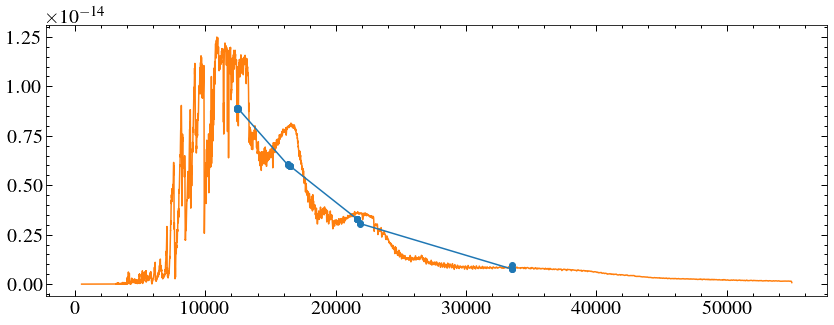

In [194]:
mask = ~data['sed_eflux'].mask
masked_data = data[mask].data

wt, ft, et = masked_data['sed_freq']*u.GHz, masked_data['sed_flux']*u.Jy, masked_data['sed_eflux']*u.Jy
#plt.errorbar(wt, ft, yerr=et, marker='o')
et = et.value/ft.value
wt = wt.to(u.AA, equivalencies=u.spectral())
ft = ft.to(u.erg / u.cm**2 / u.s / u.AA, equivalencies=u.spectral_density(wt))
et = et*ft

print(wt, ft, et)
args = np.argsort(wt)
wt, ft, et = wt[args], ft[args], et[args]
plt.errorbar(wt.value, ft.value, yerr=et.value, marker='o')
pwr, pft = smear(pw, pf*scale,2000)
plt.plot(pwr, pft)

Ok, looks like the model is a factor two out. How do we fix that? It's the model not the scaling, SP's model fits.